In [1]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Флаг для тестирования модели на небольшом подмножестве данных
TEST_MODEL = True

In [3]:
# Загрузка конфигураций из файла config_f.json
with open('config_f.json', 'r') as f:
    configs = json.load(f)

In [4]:
# Загрузка данных о скоростях
speed_data = pd.read_csv('extracteddata/_speed.csv')

In [5]:
def find_nearest_speed(image_timestamp, speed_timestamps, speeds):
    nearest_index = (np.abs(speed_timestamps - image_timestamp)).argmin()
    return speeds[nearest_index]

In [6]:
def match_speeds_to_images(speed_data, image_data_file, camera_folder):
    image_data = pd.read_csv(image_data_file)
    image_timestamps = image_data['timestamp'].values
    speed_timestamps = speed_data['timestamp'].values
    speeds = speed_data['sog'].values
    image_data['speed'] = [find_nearest_speed(ts, speed_timestamps, speeds) for ts in image_timestamps]
    image_data['image_path'] = image_data['filename'].apply(lambda filename: os.path.join("extracteddata", camera_folder, filename))
    return image_data[['image_path', 'speed']]

camera_csv_files = {
    '_camera_crop2_image_rect_color_compressed.csv': '_camera_crop2_image_rect_color_images',
    '_camera_crop3_image_rect_color_compressed.csv': '_camera_crop3_image_rect_color_images',
    '_camera_crop4_image_rect_color_compressed.csv': '_camera_crop4_image_rect_color_images',
    '_camera_crop5_image_rect_color_compressed.csv': '_camera_crop5_image_rect_color_images',
}

all_data = pd.DataFrame()

for csv_file, camera_folder in camera_csv_files.items():
    image_data_file = f'extracteddata/{csv_file}'
    matched_data = match_speeds_to_images(speed_data, image_data_file, camera_folder)
    all_data = pd.concat([all_data, matched_data], ignore_index=True)

# Разбиение на чанки по 100 изображений
def split_into_chunks(data, chunk_size=100):
    return [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

chunks = split_into_chunks(all_data)

In [7]:
# Разделение чанков на обучающую, валидационную и тестовую выборки
train_chunks, test_chunks = train_test_split(chunks, test_size=0.3, random_state=42)
validation_chunks, test_chunks = train_test_split(test_chunks, test_size=0.33, random_state=42)

# Функция для преобразования списка чанков в DataFrame
def chunks_to_dataframe(chunks):
    return pd.concat(chunks, ignore_index=True)

train_data = chunks_to_dataframe(train_chunks)
validation_data = chunks_to_dataframe(validation_chunks)
test_data = chunks_to_dataframe(test_chunks)

# Уменьшение данных для тестирования модели
if TEST_MODEL:
    train_data = train_data.sample(n=500, random_state=42)
    validation_data = validation_data.sample(n=100, random_state=42)
    test_data = test_data.sample(n=100, random_state=42)

train_data.to_csv('extracteddata/train_data.csv', index=False)
validation_data.to_csv('extracteddata/validation_data.csv', index=False)
test_data.to_csv('extracteddata/test_data.csv', index=False)

In [8]:
class ImageSpeedDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        speed = torch.tensor([self.data.iloc[idx]['speed']], dtype=torch.float)
        return image, speed

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageSpeedDataset('extracteddata/train_data.csv', transform)
validation_dataset = ImageSpeedDataset('extracteddata/validation_data.csv', transform)
test_dataset = ImageSpeedDataset('extracteddata/test_data.csv', transform)

# Определение модели CNN-LSTM с дополнительными слоями и Dropout
class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )
        self.lstm = nn.LSTM(input_size=128 * 28 * 28, hidden_size=256, num_layers=2, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1, 128 * 28 * 28)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

# Функции для тренировки и валидации модели
def train_model(dataloader, model, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, speeds in dataloader:
        images, speeds = images.to(device), speeds.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, speeds)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate_model(dataloader, model, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, speeds in dataloader:
            images, speeds = images.to(device), speeds.to(device)
            outputs = model(images)
            loss = criterion(outputs, speeds)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [9]:
# Инициализация устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Словарь для хранения результатов
results = {}

for config in configs:
    learning_rate = config['learning_rate']
    num_epochs = config['num_epochs']
    batch_size = config['batch_size']
    optimizer_name = config['optimizer']
    
    # Инициализация модели, критерия и оптимизатора
    model = CNNLSTMModel().to(device)
    criterion = nn.MSELoss()
    if optimizer_name.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unknown optimizer specified in config file")
    
    # Обучающие и валидационные загрузчики данных
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    train_losses = []
    validation_losses = []
    best_validation_loss = float('inf')
    best_model_state = None
    
    for epoch in range(num_epochs):
        train_loss = train_model(train_loader, model, criterion, optimizer)
        validation_loss = validate_model(validation_loader, model, criterion)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        
        # Сохранение модели с наилучшими результатами валидации
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            best_model_state = model.state_dict()
        
        print(f'Config: {config}, Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {validation_loss}')
    
    # Сохранение лучших результатов
    results[str(config)] = {
        "train_losses": train_losses,
        "validation_losses": validation_losses,
        "best_model_state": best_model_state,
        "best_validation_loss": best_validation_loss
    }

    # Тестирование модели
    model.load_state_dict(best_model_state)  # Загрузка лучшей модели
    test_loss = validate_model(test_loader, model, criterion)
    print(f'Config: {config}, Test Loss: {test_loss}')

Config: {'learning_rate': 0.0001, 'num_epochs': 15, 'batch_size': 64, 'optimizer': 'adam'}, Epoch 1/15, Train Loss: 2.4482813328504562, Validation Loss: 1.2852693796157837
Config: {'learning_rate': 0.0001, 'num_epochs': 15, 'batch_size': 64, 'optimizer': 'adam'}, Epoch 2/15, Train Loss: 1.2073779478669167, Validation Loss: 0.6814065277576447
Config: {'learning_rate': 0.0001, 'num_epochs': 15, 'batch_size': 64, 'optimizer': 'adam'}, Epoch 3/15, Train Loss: 0.6752132177352905, Validation Loss: 0.32862018048763275
Config: {'learning_rate': 0.0001, 'num_epochs': 15, 'batch_size': 64, 'optimizer': 'adam'}, Epoch 4/15, Train Loss: 0.344137504696846, Validation Loss: 0.22217325866222382
Config: {'learning_rate': 0.0001, 'num_epochs': 15, 'batch_size': 64, 'optimizer': 'adam'}, Epoch 5/15, Train Loss: 0.2266778964549303, Validation Loss: 0.2768799215555191
Config: {'learning_rate': 0.0001, 'num_epochs': 15, 'batch_size': 64, 'optimizer': 'adam'}, Epoch 6/15, Train Loss: 0.22158918529748917, Va

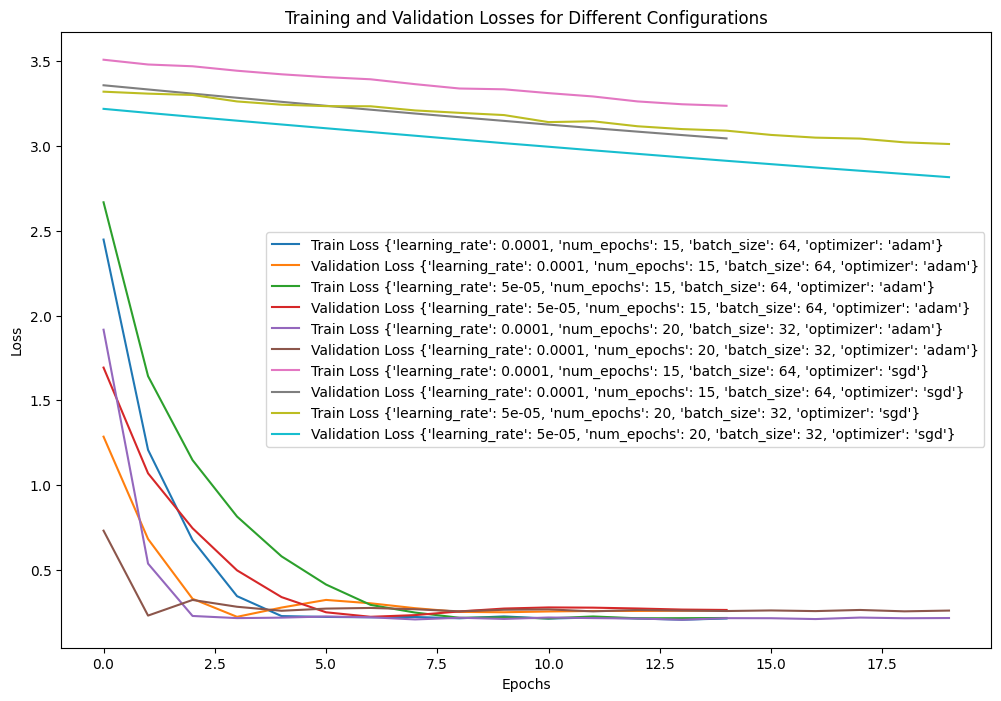

In [10]:
# Построение графиков
plt.figure(figsize=(12, 8))
for config_str, result in results.items():
    plt.plot(result["train_losses"], label=f'Train Loss {config_str}')
    plt.plot(result["validation_losses"], label=f'Validation Loss {config_str}')
plt.title('Training and Validation Losses for Different Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
